In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func
from sqlalchemy import MetaData

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
# reflect an existing database into a new model
metadata = MetaData()
metadata.reflect(bind=engine)

# reflect the tables
base = automap_base(metadata=metadata)
base.prepare()

In [20]:
# View all of the classes that automap found
print(base.classes.keys())

['measurement', 'station']


In [21]:
# Save references to each table
station = base.classes.station
measurement = base.classes.measurement

In [22]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

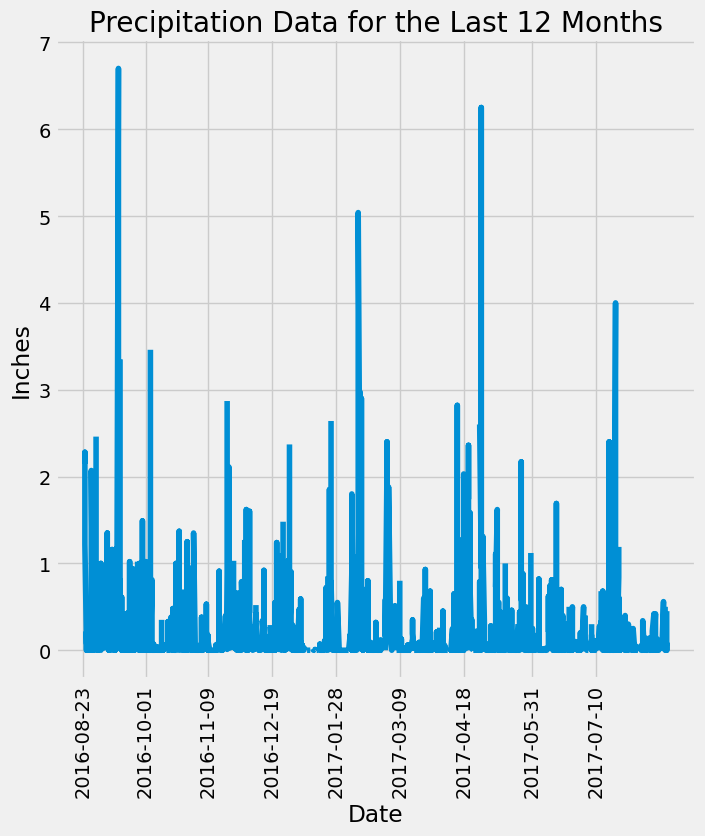

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp)\
    .filter(measurement.date >= one_year_ago, measurement.date <= most_recent_date)\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime format
df = df.sort_values('Date')

selected_dates = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10']

sorted_dates = sorted(selected_dates)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(8, 8))
plt.plot(df['Date'], df['Precipitation'])
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Data for the Last 12 Months')
plt.xticks(sorted_dates, rotation=90)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
print(total_stations)

9


In [27]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = session.query(station.station, func.count(measurement.station))\
    .filter(station.station == measurement.station)\
    .group_by(station.station)\
    .order_by(func.count(measurement.station).desc())\
    .all()

# List the stations and their counts in descending order.
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [28]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0] 

temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs))\
    .filter(measurement.station == most_active_station_id)\
    .all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Most Active Station: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp} F")
print(f"Highest Temperature: {highest_temp} F")
print(f"Average Temperature: {avg_temp} F")

Most Active Station: USC00519281
Lowest Temperature: 54.0 F
Highest Temperature: 85.0 F
Average Temperature: 71.66378066378067 F


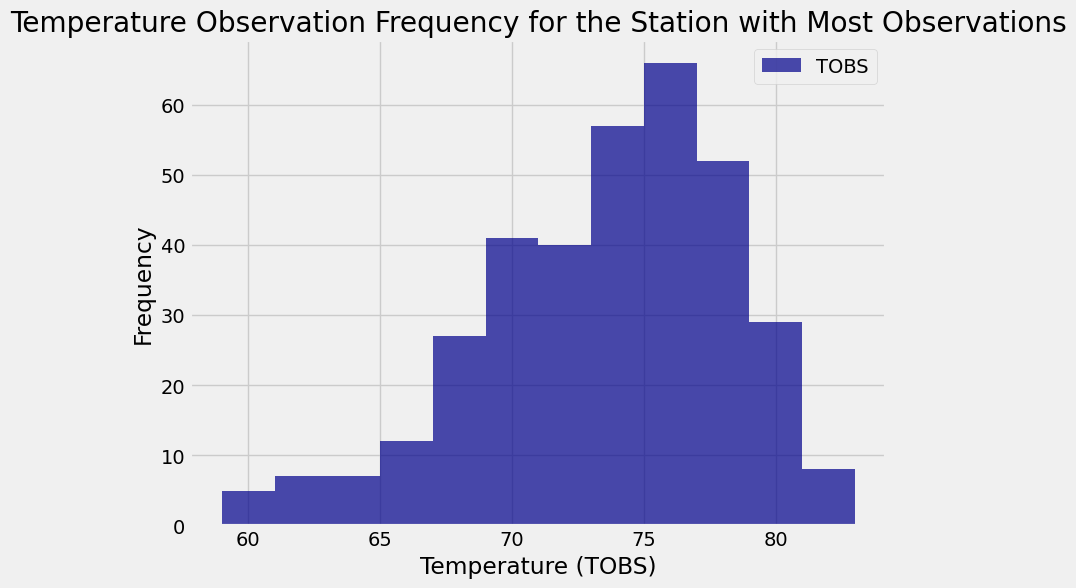

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_with_most_observations = session.query(measurement.station, func.count(measurement.station))\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.station).desc())\
    .first()[0]

most_recent_date = session.query(func.max(measurement.date)).scalar()
one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

results = session.query(measurement.tobs)\
    .filter(measurement.station == station_with_most_observations, measurement.date >= one_year_ago, measurement.date <= most_recent_date)\
    .all()

df = pd.DataFrame(results, columns=['tobs'])

plt.figure(figsize=(8, 6))
plt.hist(df['tobs'], bins=12, alpha=0.7, color='darkblue', label='TOBS')
plt.xlabel('Temperature (TOBS)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Frequency for the Station with Most Observations')
plt.legend()
plt.show()

# Close Session

In [32]:
# Close Session
session.close()